# IMPORTS

In [1]:
import keras
import numpy as np
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications.vgg16 import decode_predictions
import cv2
from keras.datasets import cifar10
from keras import backend as K
from keras.utils import np_utils
import matplotlib.pyplot as plt


from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

Using TensorFlow backend.


# BASE DE DATOS

In [0]:
nb_train_samples = 30000 
nb_valid_samples = 5000 
num_classes = 10 


def load_cifar10_data(img_rows, img_cols):

    # Se cargan los sets de cifar10 para entrenamiento y validacion.
    (x_train, y_train_norm), (x_test, y_test_norm) = cifar10.load_data()

    # Reescalado de imagenes
    if K.image_dim_ordering() == 'th':
        x_train = np.array([cv2.resize(img.transpose(1,2,0), (img_rows,img_cols)).transpose(2,0,1) for img in x_train[:nb_train_samples,:,:,:]])
        x_test = np.array([cv2.resize(img.transpose(1,2,0), (img_rows,img_cols)).transpose(2,0,1) for img in x_test[:nb_valid_samples,:,:,:]])
    else:
        x_train = np.array([cv2.resize(img, (img_rows,img_cols)) for img in x_train[:nb_train_samples,:,:,:]])
        x_test = np.array([cv2.resize(img, (img_rows,img_cols)) for img in x_test[:nb_valid_samples,:,:,:]])

    y_train = y_train_norm[:nb_train_samples]
    y_test = y_test_norm[:nb_valid_samples]

    return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = load_cifar10_data(224, 224)

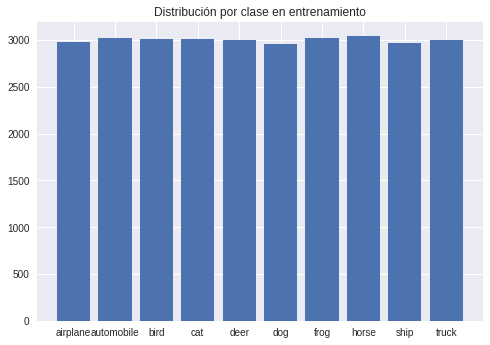

In [3]:
# cantidad de elementos por clase
cantidad_clase = np.array([0]*10)
for i in range(0,len(y_train)):
  clase = y_train[i]
  cantidad_clase[clase] = cantidad_clase[clase] + 1
  
clases = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

plt.bar(clases, cantidad_clase)
plt.title('Distribución por clase en entrenamiento')
plt.show()
    
  

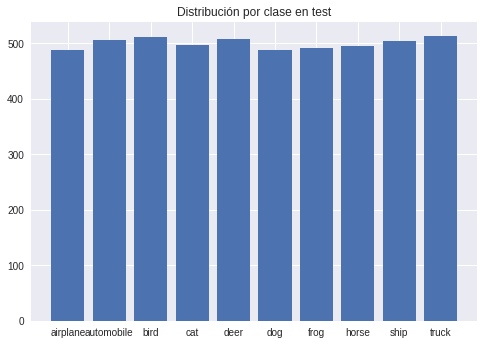

In [4]:
cantidad_clase = np.array([0]*10)
for i in range(0,len(y_test)):
  clase = y_test[i]
  cantidad_clase[clase] = cantidad_clase[clase] + 1
  
plt.bar(clases, cantidad_clase)
plt.title('Distribución por clase en test')
plt.show()

In [0]:
# transformar a variables categoricas

y_train_cat = np_utils.to_categorical(y_train[:nb_train_samples], num_classes)
y_test_cat = np_utils.to_categorical(y_test[:nb_valid_samples], num_classes)

# TRANFER LEARNING


## Cargar red

In [0]:
model1 = VGG16(weights='imagenet', include_top=True, input_shape = (224, 224, 3))

## Modificar clasificador

In [7]:
#fijar pesos
for layer in model1.layers[0:19]:
    layer.trainable = False
    
# agregando capas

x = model1.layers[19].output
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(64, activation="relu")(x)
predictions = Dense(10, activation="softmax")(x)


modelo_final = Model(input = model1.input, output = predictions)
modelo_final.compile(loss = "categorical_crossentropy", optimizer = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999), metrics=["accuracy"])

# Save the model according to the conditions  
checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=1, mode='auto')

modelo_final.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  del sys.path[0]


In [0]:

callbacks = [checkpoint, early]
training = modelo_final.fit(x=x_train, y=y_train_cat,
                            batch_size=50, epochs=20, verbose=1, callbacks=callbacks,
                            validation_split=0.0, validation_data=(x_test,y_test_cat), 
                            shuffle=True, class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None,
                            validation_steps=None)

Train on 30000 samples, validate on 5000 samples
Epoch 1/20
30000/30000 [==============================] - 365s 12ms/step - loss: 2.8325 - acc: 0.5257 - val_loss: 0.9781 - val_acc: 0.7060

Epoch 00001: val_acc improved from -inf to 0.70600, saving model to vgg16_1.h5
Epoch 2/20
30000/30000 [==============================] - 359s 12ms/step - loss: 1.0733 - acc: 0.6681 - val_loss: 0.8862 - val_acc: 0.7352

Epoch 00002: val_acc improved from 0.70600 to 0.73520, saving model to vgg16_1.h5
Epoch 3/20
 7950/30000 [======>.......................] - ETA: 3:46 - loss: 0.9290 - acc: 0.7164

In [0]:

# summarize history for accuracy
plt.plot(training.history['acc'])
plt.plot(training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()






In [0]:

plt.plot(training.history['loss'])
plt.plot(training.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix




def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()



In [0]:

Y_pred = modelo_final.predict(x_test)
y_pred = np.argmax(Y_pred, axis=1)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=clases,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=clases, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [0]:
# serialize model to JSON
model_json = modelo_final.to_json()
with open("model1.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
modelo_final.save_weights("model1.h5")
print("Saved model to disk")


Saved model to disk


# ENTRENAMIENTO DESDE PESOS IMAGENET

A continuación, se entrena la red a parter de los pesos de $\textit{ImageNet}$.


In [8]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
path = 'gdrive/My Drive/UNIVERSIDAD/SEMESTRE PRIMAVERA 2018/INTELIGENCIA COMPUTACIONAL/Proyecto de inteligencia/MEETING 5/pesos_clasificador.h5'
modelo_final.load_weights(path)

In [0]:
# seleccionar capas entrenables
for layer in modelo_final.layers[0:15]:
    layer.trainable = False
    

for layer in modelo_final.layers[15:]:
    layer.trainable = True

callbacks = [checkpoint, early]    

In [11]:

training = modelo_final.fit(x=x_train, y=y_train_cat,
                            batch_size=50, epochs=20, verbose=1, callbacks=callbacks,
                            validation_split=0.0, validation_data=(x_test,y_test_cat), 
                            shuffle=True, class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None,
                            validation_steps=None)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Train on 30000 samples, validate on 5000 samples
Epoch 1/20
30000/30000 [==============================] - 364s 12ms/step - loss: 0.3730 - acc: 0.8817 - val_loss: 0.7487 - val_acc: 0.8142

Epoch 00001: val_acc improved from -inf to 0.81420, saving model to vgg16_1.h5
Epoch 2/20
30000/30000 [==============================] - 358s 12ms/step - loss: 0.3553 - acc: 0.8840 - val_loss: 0.7565 - val_acc: 0.8172

Epoch 00002: val_acc improved from 0.81420 to 0.81720, saving model to vgg16_1.h5
Epoch 3/20
30000/30000 [==============================] - 358s 12ms/step - loss: 0.3476 - acc: 0.8865 - val_loss: 0.7393 - val_acc: 0.8206

Epoch 00003: val_acc improved from 0.81720 to 0.82060, saving model to vgg16_1.h5
Epoch 4/20
30000/30000 [==============================] - 358s 12ms/step - loss: 0.3426 - acc: 0.8878 - val_loss: 0.7667 - val_acc: 0.8122

Epoch 00004: val_acc did not improve from 0.82060
Epoch 5/20
30000/30000 [==============================] - 358s 12ms/step - loss: 0.3312 - acc: 0.8

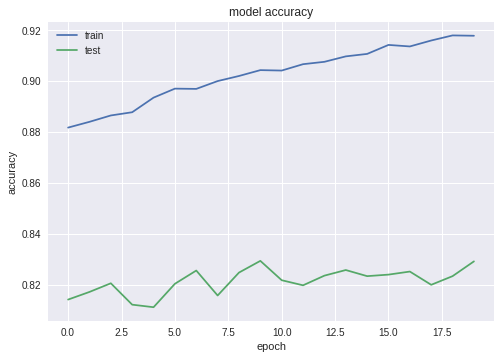

In [12]:
plt.plot(training.history['acc'])
plt.plot(training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

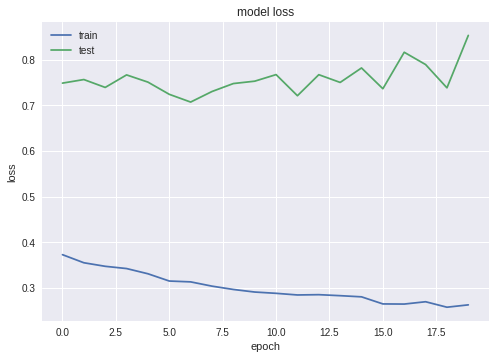

In [13]:
plt.plot(training.history['loss'])
plt.plot(training.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()